![Imagen de WhatsApp 2024-12-10 a las 14.18.02_af748ca0.jpg](<attachment:Imagen de WhatsApp 2024-12-10 a las 14.18.02_af748ca0.jpg>)
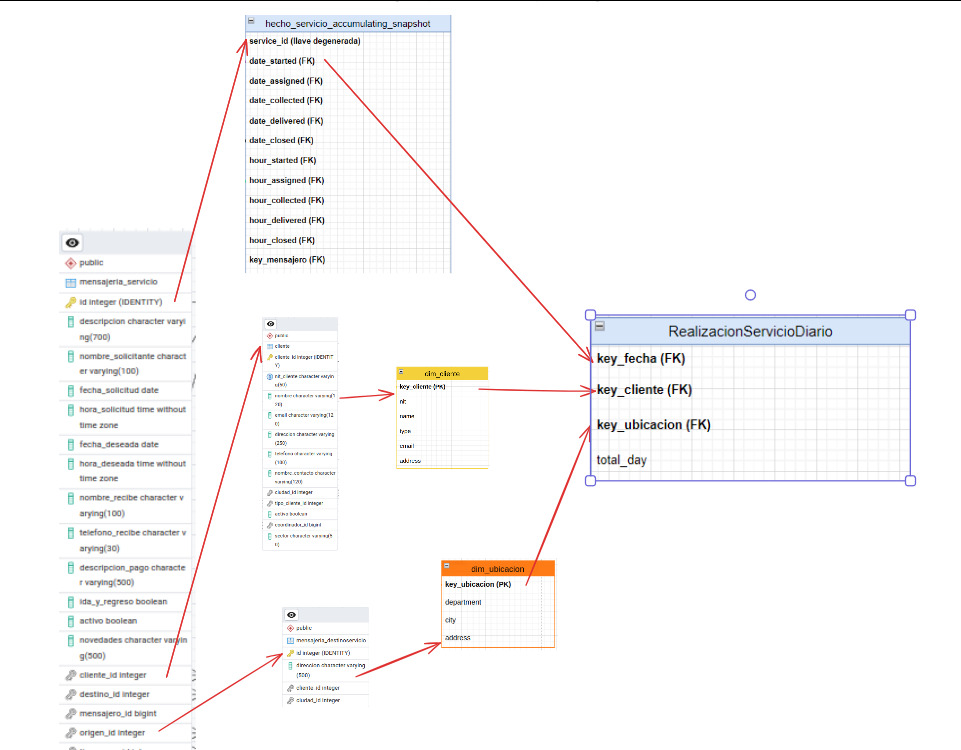

## Importar librerías

In [ ]:
import pandas as pd
import sqlalchemy as sa
import utils.conn_tools as ct

## Conexión con base de datos

In [ ]:
config = ct.readConfig("../config/config-postgres.yaml")

config_src = config["source"]
config_etl = config["warehouse"]

engine_src = sa.create_engine(ct.generateConnUrl(config_src))
engine_etl = sa.create_engine(ct.generateConnUrl(config_etl))

### Asimilación de dimensiones

In [ ]:
# Create table
metadata = sa.MetaData()

metadata.reflect(bind=engine_etl)  # Reflect helps to get existing tables

## Extract

In [ ]:
# Leer los datos de las tablas

# De la fuente
msj_servicio = pd.read_sql_table("mensajeria_servicio", con=engine_src)
cliente = pd.read_sql_table("cliente", con=engine_src)
cliente_usuario = pd.read_sql_table("clientes_usuarioaquitoy", con=engine_src)

# Del Warehouse
dim_cliente = pd.read_sql_table("dim_cliente", con=engine_etl)
dim_mensajero = pd.read_sql_table("dim_mensajero", con=engine_etl)
dim_ubicacion = pd.read_sql_table("dim_ubicacion", con=engine_etl)
hecho_servicio_accumulating_snapshot = pd.read_sql_table("hecho_servicio_accumulating_snapshot", con=engine_etl)

## Transform

In [ ]:
# Crear DataFrame con los datos de servicios (solo necesarios)
merged_df = pd.DataFrame(
    {
        "servicio_id": msj_servicio["id"],
        "cliente_id": msj_servicio["cliente_id"],
        "usuario_id": msj_servicio["usuario_id"],
    }
)

# Combinar con el hecho para obtener las fechas
merged_df = merged_df.merge(
    hecho_servicio_accumulating_snapshot,
    left_on="servicio_id",
    right_on="service_id",
    suffixes=("_mdf", "_hecho"),
)

# Limpiar para quedarse unicamente con la fecha deseada
merged_df = pd.DataFrame(
    {
        "key_fecha": merged_df["date_started"],
        "cliente_id": merged_df["cliente_id"],
        "usuario_id": merged_df["usuario_id"],
    }
)

In [ ]:
# Combinar con cliente para ver el nit_cliente
merged_df = merged_df.merge(
    cliente,
    left_on="cliente_id",
    right_on="cliente_id",
    suffixes=("_mdf", "_dimcli"),
)

# Combinar con dim_cliente usando el nit_cliente - nit
merged_df = merged_df.merge(
    dim_cliente,
    left_on="nit_cliente",
    right_on="nit",
    suffixes=("_mdf", "_dimcli"),
)

# Limpiar para quedarse unicamente con el key_cliente
merged_df = pd.DataFrame(
    {
        "key_fecha": merged_df["key_fecha"],
        "key_cliente": merged_df["key_cliente"],
        "usuario_id": merged_df["usuario_id"],
    }
)

print(f"Cantidad de filas después de la limpieza: {merged_df.shape[0]}")
merged_df.head(3)

In [ ]:
# Combinar con `cliente_usuario` para obtener sede de cliente
merged_df = merged_df.merge(
    cliente_usuario,
    left_on="usuario_id",
    right_on="id",
    suffixes=("_mdf", "_clieusr"),
)

# Combinar con `dim_ubicacion_unique` para incluir solo la primera ocurrencia de cada dirección
merged_df = merged_df.merge(
    dim_ubicacion,
    left_on="sede_id",
    right_on="old_sede_id",
    suffixes=("_mdf", "_dimubi"),
)

# Extraer solo datos necesarios
merged_df = pd.DataFrame(
    {
        "key_fecha": merged_df["key_fecha"],
        "key_cliente": merged_df["key_cliente"],
        "key_ubicacion": merged_df["key_ubicacion"],
    }
)

print(merged_df.count())
merged_df.head(3)

In [ ]:
# Group if key_fecha, key_cliente and key_ubicacion are the same and add a column with the quantity of coincidences per group

merged_df = merged_df.groupby(["key_fecha", "key_cliente", "key_ubicacion"]).size().reset_index(name="total_at_day")
merged_df.head(5)

## Load: Ejecución de ETL

In [ ]:
hecho_realizacion_servicio_dia_table = sa.Table(
    "hecho_realizacion_servicio_dia",
    metadata,
    # Primary key
    sa.Column(
        "key_hecho_realizacion_servicio_dia",
        sa.Integer,
        primary_key=True,
        autoincrement=True,
    ),
    # Dimension keys
    sa.Column("key_fecha", sa.Integer, sa.ForeignKey("dim_fecha.key_fecha")),
    sa.Column("key_cliente", sa.Integer, sa.ForeignKey("dim_cliente.key_cliente")),
    sa.Column("key_ubicacion", sa.Integer, sa.ForeignKey("dim_ubicacion.key_ubicacion")),
    sa.Column("total_at_day", sa.Integer),
)

metadata.create_all(engine_etl)

In [ ]:
merged_df.to_sql(
    name="hecho_realizacion_servicio_dia",
    con=engine_etl,
    if_exists="append",
    index=False,
)